============================================================================================

# RandomForest

============================================================================================


In [1]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import os
import re
import random
import time
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.decomposition import PCA

import fns_models as fns


% matplotlib inline

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf-8"))

athenaeum_authors_preview.csv
athenaeum_painting_filtered.csv
athenaeum_paintings.csv
athenaeum_paintings_sizes.csv
color_histograms.csv
complete_data.csv
extra_tree_com.csv
grad_boost_com.csv
images
images_athenaeum
images_sizes_2325.csv
net_predicted.csv
painter_info_clean.csv
painting_info_clean.csv
resized_200
test_author200.csv
test_data.csv
test_hist_author_knn.csv
test_hist_author_rf.csv
train_author200.csv
train_data.csv
train_hist_author_knn.csv
train_hist_author_rf.csv



In [3]:
train, train_labels, test, test_labels = fns.get_top_author(3)


[INFO] The size of train histogram for Random Forest(49890, 35)
[INFO] The size of test histogram for Random Forest(12473, 35)
24      1369
1793    1338
368     1335
Name: author_id, dtype: int64
[trian above] ==================================================[test below]
24      342
1793    335
368     334
Name: author_id, dtype: int64
(4042,)
(4042, 35)


================================================================================================================

# Bayesian Optimization + Random Forest

[bayesian-optimization](https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py)

================================================================================================================

In [4]:
def rf_evaluate(max_features, max_depth, n_estimators):
    
    random.seed(2017)
#     params['max_features'] = int(max_features)
#     params['max_depth'] = int(max_depth)
#     params['n_estimators'] = int(n_estimators)
    
    rfc = RandomForestClassifier(n_jobs = 4, n_estimators=int(n_estimators), oob_score=True,
                                max_depth = int(max_depth), max_features = int(max_features))
    #scores = cross_val_score(rfc, X=train, y = train_labels, cv=5, n_jobs = 2)
    
    # The mean score and the 95% confidence interval of the score estimate are hence given by:
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    #return scores.mean()
    rfc.fit(train, train_labels)
    return rfc.oob_score_

def rf_pca_evaluate(max_features,
                    max_depth,
                    n_estimators):
    
    random.seed(2017)
    
    rfc = RandomForestClassifier(n_jobs = 4, n_estimators=int(n_estimators), oob_score=True,
                                max_depth = int(max_depth), max_features = int(max_features))
    
    rfc.fit(pca_transformed, train_labels)
    return rfc.oob_score_

def rf_bo(rf_fnc=rf_evaluate):
    start_time = time.time()
    num_iter = 25
    init_points = 5
    random_state = 2017
    # params = {
    #     #'eta': 0.1,
    #     #'silent': 1,
    #     'eval_metric': 'mae',
    #     'verbose_eval': True,
    #     #'seed': random_state
    # }

    rfBO = BayesianOptimization(rf_fnc, {'max_features': (5, 7),
                                             'max_depth': (2, 10),
                                             'n_estimators': (100, 720)})

    rfBO.maximize(init_points=init_points, n_iter=num_iter)
    print('-' * 53)
    print 'Costed time: \n%f' % (time.time() - start_time)
    
    print "Bayesian Optimization Best Score: %f" % rfBO.res['max']['max_val']

    print "Bayesian Optimization Best Parameters: %s" % str(rfBO.res['max']['max_params'])
    
    print (rfBO.res['max'])
    
#     fns.plot_bo(rf_fnc, rfBO)

#     print "Bayesian Optimization  Parameters: %s" % str(rfBO.res['all'])



In [5]:
# Run BO for color histogram
rf_bo(rf_evaluate)

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 00m06s |    0.67392 |      7.9940 |         5.5696 |       477.0931 | 
    2 | 00m07s |    0.68728 |      9.7176 |         6.3575 |       499.4903 | 
    3 | 00m05s |    0.66155 |      6.8852 |         6.6994 |       390.4199 | 
    4 | 00m04s |    0.64448 |      5.6782 |         5.9174 |       358.4043 | 
    5 | 00m02s |    0.66353 |      6.8468 |         6.8560 |       176.9217 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 00m21s |    0.59476 |      2.1977 |         6.7143 |       719.9367 | 
    7 | 00m08s |    0.68530 |      9.3571 |         6.9973 |       100.0350 | 
    8 | 00m17s |    0.69050 |      9.9859 |         6.7287 |       589.7670 | 
    9 | 00m15s | 

/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.48832769e-05]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)


   19 | 00m17s |    0.69891 |     10.0000 |         7.0000 |       456.6774 | 
   20 | 00m15s |    0.68654 |      9.9857 |         6.9466 |       322.6136 | 
   21 | 00m18s |    0.69767 |     10.0000 |         7.0000 |       281.0554 | 
   22 | 00m15s |    0.68629 |      9.8626 |         6.9470 |       117.6207 | 
   23 | 00m27s |    0.70089 |     10.0000 |         7.0000 |       654.0983 | 
   24 | 00m21s |    0.68481 |      9.8720 |         6.9704 |       661.1967 | 
   25 | 00m11s |    0.59574 |      2.0350 |         7.0000 |       127.8315 | 


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.73755060e-05]), 'nit': 5, 'funcalls': 55}
  " state: %s" % convergence_dict)


   26 | 00m22s |    0.69767 |     10.0000 |         7.0000 |       639.1012 | 
   27 | 00m13s |    0.69050 |      9.9746 |         6.9016 |       196.8099 | 


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00010053]), 'nit': 6, 'funcalls': 56}
  " state: %s" % convergence_dict)


   28 | 00m13s |    0.68135 |      9.9786 |         6.7980 |       156.8125 | 
   29 | 00m21s |    0.68803 |      9.9550 |         6.9078 |       695.8416 | 
   30 | 00m18s |    0.68382 |      9.9956 |         6.9743 |       373.5136 | 
-----------------------------------------------------
Costed time: 
436.890886
Bayesian Optimization Best Score: 0.700891
Bayesian Optimization Best Parameters: {'max_features': 7.0, 'n_estimators': 654.09827233352632, 'max_depth': 10.0}
{'max_val': 0.70089064819396341, 'max_params': {'max_features': 7.0, 'n_estimators': 654.09827233352632, 'max_depth': 10.0}}


In [23]:
# Choose the best params from BO results then predict 
best_estimators = 654
best_max_depth = 6
best_max_features = 7
best_rfc = RandomForestClassifier(n_jobs = 4, n_estimators=best_estimators, oob_score=False,
                                max_depth = best_max_depth, max_features = best_max_features)

best_rfc.fit(train, train_labels)

# accuracy of trianing dataset
print "Accuracy of best Random Forest model on train: %s" % str(best_rfc.score(train, train_labels))

# accuracy of testing dataset
print "Accuracy of best Random Forest model on test: %s" % str(best_rfc.score(test, test_labels))


# use the best params to predict
rfc_true, rfc_pred = test_labels, best_rfc.predict(test)
rfc_pred

Accuracy of best Random Forest model on train: 0.737258782781
Accuracy of best Random Forest model on test: 0.686449060336


array([  24, 1793, 1793, ..., 1793,   24, 1793])

In [33]:
best_rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=654, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
import pickle

# save the model to disk
filename = 'random_forest.sav'
pickle.dump(best_rfc, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_rfc = pickle.load(open(filename, 'rb'))
result = loaded_rfc.score(test, test_labels)
print(result)

0.686449060336


In [32]:
rf_test_df = fns.result_table(rfc_true, rfc_pred)
rf_test_df = rf_test_df.rename(index=str, columns={'predictions': 'rf_pred', 'results': 'rf_res'})
rf_test_df


,actual,rf_pred,rf_res
33,24,24,True
34,1793,1793,True
35,1793,1793,True
37,1793,1793,True
101,1793,1793,True
102,1793,1793,True
105,1793,1793,True
217,1793,24,False
261,1793,1793,True
295,1793,1793,True


In [27]:
rf_test_df.groupby(['actual', 'rf_pred']).aggregate({'rf_res': 'count'}).unstack()

rf_res          
rf_pred   24   368  1793
actual                  
24         234   48   60
368         39  224   71
1793        38   61  236

================================================================================================================

# PCA

================================================================================================================

In [55]:
## Get 15 principal components
pca = PCA(n_components=20)
pca.fit(train)
pca_transformed = pca.transform(train)

pca_transformed_test = pca.transform(test)

0.99703072537056614

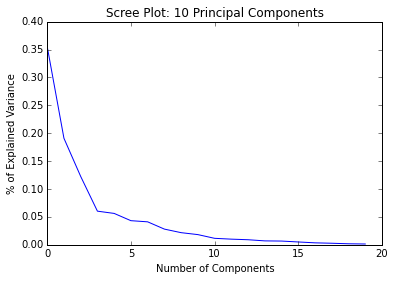

In [56]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

======================================================================================================

# Random Forest + PCA

======================================================================================================

In [11]:
# Run BO for pca of color histogram
rf_bo(rf_pca_evaluate)

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 00m04s |    0.56358 |      2.6284 |         6.4277 |       530.4468 | 
    2 | 00m06s |    0.62865 |      5.9855 |         6.9211 |       558.7029 | 
    3 | 00m05s |    0.58832 |      3.5851 |         5.7812 |       594.1779 | 
    4 | 00m06s |    0.59401 |      3.9791 |         5.6445 |       588.9019 | 
    5 | 00m04s |    0.63013 |      5.9280 |         5.7369 |       322.3853 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 00m19s |    0.66452 |     10.0000 |         7.0000 |       100.0000 | 
    7 | 00m22s |    0.66576 |     10.0000 |         7.0000 |       720.0000 | 
    8 | 00m11s |    0.66329 |      9.7643 |         6.9618 |       206.3093 | 
    9 | 00m14s | 

/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.89450110e-05]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)


   26 | 00m24s |    0.66378 |      9.9164 |         6.6623 |       567.0699 | 
   27 | 00m20s |    0.66353 |      9.9783 |         5.0921 |       217.3870 | 
   28 | 00m18s |    0.66329 |      9.9081 |         5.0209 |       185.8774 | 
   29 | 00m23s |    0.66848 |      9.9996 |         5.2258 |       310.8649 | 
   30 | 00m29s |    0.66972 |      9.9361 |         6.9127 |       684.3192 | 
-----------------------------------------------------
Costed time: 
472.395768
Bayesian Optimization Best Score: 0.672192
Bayesian Optimization Best Parameters: {'max_features': 6.846765029205554, 'n_estimators': 674.16932953229752, 'max_depth': 9.9510146776519939}
{'max_val': 0.67219198416625436, 'max_params': {'max_features': 6.846765029205554, 'n_estimators': 674.16932953229752, 'max_depth': 9.9510146776519939}}


In [24]:
# Choose the best params from BO results then predict 
best_pca_estimators = 674
best_pca_max_depth = 6
best_pca_max_features = 7
best_pca_rfc = RandomForestClassifier(n_jobs = 4, n_estimators=best_pca_estimators, oob_score=False,
                                max_depth = best_pca_max_depth, max_features = best_pca_max_features)

best_pca_rfc.fit(pca_transformed, train_labels)

# accuracy for the train set
print "Accuracy of the Model on training set:" + str(best_pca_rfc.score(pca_transformed,train_labels))

# accuracy for the test set
print "Accuracy of the Model on testing set:" + str(best_pca_rfc.score(pca_transformed_test,test_labels))

# use the best params to predict
rfc_pac_true, rfc_pca_pred = test_labels, best_pca_rfc.predict(pca_transformed_test)
rfc_pca_pred

Accuracy of the Model on training set:0.724888668976
Accuracy of the Model on testing set:0.668644906034


array([  24, 1793, 1793, ..., 1793,   24, 1793])

In [38]:
import pickle

# save the model to disk
filename = 'random_forest_pca.sav'
pickle.dump(best_pca_rfc, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_rfc_pca = pickle.load(open(filename, 'rb'))
result_pca = loaded_rfc_pca.score(pca_transformed_test, test_labels)
print(result_pca)

0.668644906034


In [25]:
pca_rf_test_df = fns.result_table(rfc_pac_true, rfc_pca_pred)
pca_rf_test_df = pca_rf_test_df.rename(index=str, columns={'predictions': 'rf_pca_pred', 'results': 'rf_pca_res'})
pca_rf_test_df

,actual,rf_pca_pred,rf_pca_res
33,24,24,True
34,1793,1793,True
35,1793,1793,True
37,1793,1793,True
101,1793,368,False
102,1793,1793,True
105,1793,1793,True
217,1793,24,False
261,1793,1793,True
295,1793,1793,True


In [28]:
pca_rf_test_df.groupby(['actual', 'rf_pca_pred']).aggregate({'rf_pca_res': 'count'}).unstack()


rf_pca_res          
rf_pca_pred       24   368  1793
actual                          
24                 229   49   64
368                 42  214   78
1793                45   57  233

In [29]:
rf_com = rf_test_df.merge(pca_rf_test_df, how='inner', on='actual')
rf_com

,actual,rf_pred,rf_res,rf_pca_pred,rf_pca_res
0,24,24,True,24,True
1,24,24,True,24,True
2,24,24,True,1793,False
3,24,24,True,368,False
4,24,24,True,1793,False
5,24,24,True,24,True
6,24,24,True,368,False
7,24,24,True,24,True
8,24,24,True,1793,False
9,24,24,True,24,True


In [30]:
rf_com.to_csv('data/rf_com.csv', index=False)

In [61]:
random_forest = ['random_forest', 0.686449060336, 0.668644906034]
xgboost = ['xgboost', 0.79440870856, 0.71315529179]
naive_bayes = ['naive_bayes', 0.59940652819, 0.623145400593]
extra_tree = ['extra_tree', 0.673590504451, 0.660731948566]
pd.DataFrame([random_forest, xgboost, naive_bayes, extra_tree], columns=['model_name', 'color_hist', 'pca'])

,model_name,color_hist,pca
0,random_forest,0.686449,0.668645
1,xgboost,0.794409,0.713155
2,naive_bayes,0.599407,0.623145
3,extra_tree,0.673591,0.660732
